# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

from tqdm import tqdm, trange
import math
import itertools

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
H_BAR = scipy.constants.hbar

GAUSS = 1e-4 # T

# Helper Functions

In [3]:
def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def simple_fidelity(k,g):
    g2 = g**2
    k2 = k**2
    return  1 - (4*g2+g2**2)/(16*k2)

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [4]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

In [5]:
def three_rabi(k,g,p=2,t_steps=10000):
    
    # fig, ax = plt.subplots(figsize=(6,4.5))
    
    coeff = [1, 2*k, -(1+g**2),-2*k]
    roots = np.roots(coeff)
    a=roots[0]
    b=roots[1]
    c=roots[2]
    # print(a,b,c)

    normalisation = 1/((a-b)*(c-a)*(b-c))**2

    coefficients = np.array([
        [a*(b - c)*(2*k+a),b*(c - a)*(2*k+b),c*(a - b)*(2*k+c)],
        [(b - c)*(2*k+a),(c - a)*(2*k+b),(a - b)*(2*k+c)],
        [g*a*(b - c),g*b*(c - a),g*c*(a - b)]
    ])

    averages = np.sum(coefficients**2,1)

    beatAmplitudes=2*np.array([
        [coefficients[0,0]*coefficients[0,1],coefficients[0,2]*coefficients[0,0],coefficients[0,1]*coefficients[0,2]],
        [coefficients[1,0]*coefficients[1,1],coefficients[1,2]*coefficients[1,0],coefficients[1,1]*coefficients[1,2]],
        [coefficients[2,0]*coefficients[2,1],coefficients[2,2]*coefficients[2,0],coefficients[2,1]*coefficients[2,2]]
    ])

    beatFrequencies = np.array([a-b,c-a,b-c])/2

    MAX_T = 2*np.pi*p
    t=np.linspace(0,MAX_T,t_steps)
    coses = np.cos(t[:,None] * beatFrequencies[None,:])

    prob = normalisation * np.array([
        averages[0]+beatAmplitudes[0,0]*coses[:,0]+beatAmplitudes[0,1]*coses[:,1]+beatAmplitudes[0,2]*coses[:,2],
        averages[1]+beatAmplitudes[1,0]*coses[:,0]+beatAmplitudes[1,1]*coses[:,1]+beatAmplitudes[1,2]*coses[:,2],
        averages[2]+beatAmplitudes[2,0]*coses[:,0]+beatAmplitudes[2,1]*coses[:,1]+beatAmplitudes[2,2]*coses[:,2]
    ])

    line_width=1.5
    
    return t,prob

# Simulator

In [6]:
def UnitaryTimeEvolution(angular,coupling,pulse_time=100e-6,initial=0,intended=1, time_steps=13421):
    N_STATES = len(angular)

    # Construct coupling matrix

    driving = np.abs(angular[intended]-angular[initial])
    coupling *= 2*np.pi/pulse_time

    # Construct
    T_MAX = 6*np.pi / coupling[initial,intended]
    T_STEPS = time_steps
    times, DT = np.linspace(0, T_MAX, num=T_STEPS, retstep=True)

    Ts = []
    for t in times:
        T  = np.zeros((N_STATES,N_STATES), dtype=np.cdouble)
        for i in range(N_STATES):
            for j in range(N_STATES):
                T[i,j] = np.exp((1j)*(angular[i]-angular[j]-driving)*t) + np.exp((1j)*(angular[i]-angular[j]+driving)*t)
        Ts.append(T)
    Ts = np.array(Ts)

    # Construct Hamiltonians
    H = np.array([H_BAR/2 * np.multiply(coupling, T) for T in Ts])


    # Move State

    finals = np.empty((T_STEPS,N_STATES))

    state = np.zeros(N_STATES) # initial state
    state[initial] = 1


    for i in range(T_STEPS):
        unitary = scipy.linalg.expm(-(1j)*(DT/H_BAR)*H[i])
        state = np.matmul(unitary,state)
        finals[i]=(np.abs(state)**2)
        
    return times,finals

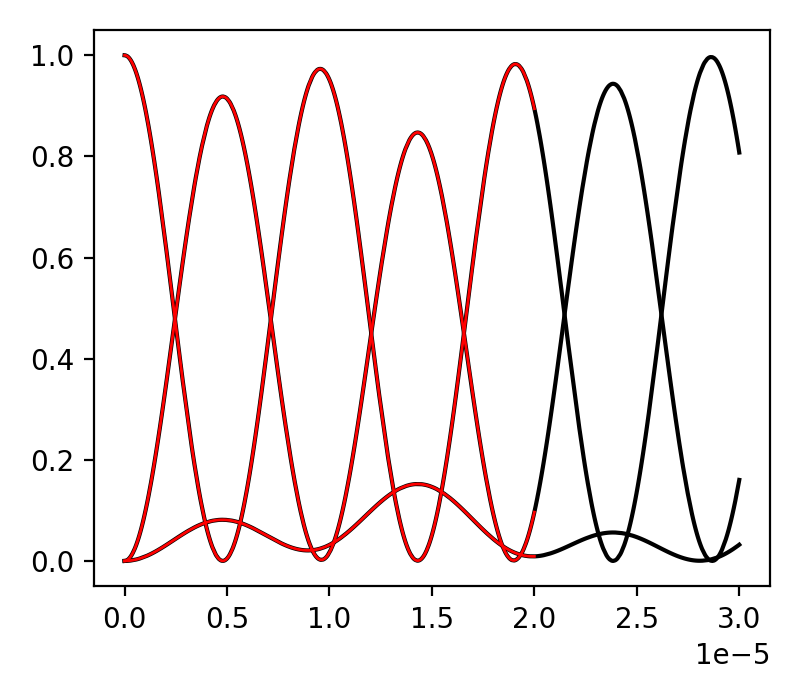

In [7]:
pt = 10*1e-6
rot_gap = 1e9
delta = 100e3
g = 0.3

rabi = (2*np.pi)/pt
k = delta/rabi


times,r = UnitaryTimeEvolution(np.array([0,rot_gap,rot_gap+delta]),np.array([[0,1,g],[1,0,0],[g,0,0]]),pulse_time=pt, time_steps=131071)


tau,r_anal = three_rabi(k,g)

fig,ax=plt.subplots()
ax.plot(times,r,c='k')
ax.plot(tau/rabi,r_anal.T,c='r',lw=1)

In [8]:
def peakProbabilities(angular, coupling, pulse_time=100e-6, initial=0, intended=1, time_steps=10000):
    """
    angular - 1D numpy array of angular frequencies (via w=E/H_BAR)
    coupling - 2D numpy coupling (symmetric) matrix between states
    pulse_time - intended 2-Pi pulse duration in seconds
    initial - index of initial state in angular
    intended - index of intended state in angular
    time_steps - number of timesteps to simulate
    """

    # Pick incoming radiation parameters
    driving = angular[intended] - angular[initial] 
    # print("driving:",driving)
    E_0 = np.abs((2*np.pi*H_BAR) / (coupling[initial, intended] * pulse_time))

    # Make times
    times, DT = np.linspace(0, pulse_time*3.0, num=time_steps, retstep=True)# [ti], []

    # Construct 'kinetic' time step operator (Matrix Diagonal)
    T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

    # Construct potential fixed part time step operator 
    ORDER = 20
    V_TI_M = (-(1j)*DT/H_BAR)*E_0*coupling
    V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

    # Initial state
    N_STATES = len(angular)
    state_vector = np.zeros((N_STATES), dtype=np.cdouble)
    state_vector[initial] = 1
    # max_amp_vector = np.zeros((N_STATES), dtype=np.double)
    # max_amp_vector[initial] = 1
    
    state_vectors = np.zeros((time_steps,N_STATES), dtype=np.cdouble) 
    state_vectors[0] = state_vector
    
    V_TDS = np.cos(driving*times) #[ti]
    V_TDS_POWS = V_TDS**(np.arange(ORDER)[:,None]) #[c,ti]
    
    V_OPS = np.sum(V_TI_M_POWS[:,None,:,:]*V_TDS_POWS[:,:,None,None], axis=0) #[ti,s,s]
    DUS =  T_OP_DIAG[None,:,None] * V_OPS * T_OP_DIAG[None,None,:]
    
    # state_vectors = np.zeros((time_steps,N_STATES), dtype=np.double)

    # Run differential equation
    for t_num in range(time_steps-1):
#        V_TD = np.cos(driving*times[t_num])
#        V_TD_POWS = V_TD**np.arange(ORDER)

#        V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None], axis=0)

#        DU = T_OP_DIAG[:,None] * V_OP * T_OP_DIAG[None,:]  # = T @ V @ T
        state_vector = DUS[t_num] @ state_vector
        state_vectors[t_num+1] = state_vector
        # state_vectors[t_num] = state_vector
        # max_amp_vector = np.maximum(max_amp_vector, np.abs(state_vector))
        
    # fig,ax=plt.subplots()
    # ax.plot(times,np.abs(state_vectors)**2)
    # ax.set_title("peakprob")

    return times, state_vectors #, state_vectors

In [9]:
def peakProbabilitiesSympathetic(angular, coupling, pulse_time=100e-6, initial=0, intended=1, sympathetic=2, time_steps=10000):
    """
    angular - 1D numpy array of angular frequencies (via w=E/H_BAR)
    coupling - 2D numpy coupling (symmetric) matrix between states
    pulse_time - intended 2-Pi pulse duration in seconds
    initial - index of initial state in angular
    intended - index of intended state in angular
    time_steps - number of timesteps to simulate
    """

    # Pick incoming radiation parameters
    driving = angular[intended] - angular[initial] 
    # print("driving:",driving)
    E_0 = np.abs((2*np.pi*H_BAR) / (coupling[initial, intended] * pulse_time))

    # Make times
    times, DT = np.linspace(0, pulse_time*3.0, num=time_steps, retstep=True)# [ti], []

    # Construct 'kinetic' time step operator (Matrix Diagonal)
    T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

    # Construct potential fixed part time step operator 
    ORDER = 20
    V_TI_M = (-(1j)*DT/H_BAR)*E_0*coupling
    V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

    # Initial state
    N_STATES = len(angular)
    state_vector = np.zeros((N_STATES), dtype=np.cdouble)
    state_vector[sympathetic] = 1
    # max_amp_vector = np.zeros((N_STATES), dtype=np.double)
    # max_amp_vector[initial] = 1
    
    state_vectors = np.zeros((time_steps,N_STATES), dtype=np.cdouble) 
    state_vectors[0] = state_vector
    
    V_TDS = np.cos(driving*times) #[ti]
    V_TDS_POWS = V_TDS**(np.arange(ORDER)[:,None]) #[c,ti]
    
    V_OPS = np.sum(V_TI_M_POWS[:,None,:,:]*V_TDS_POWS[:,:,None,None], axis=0) #[ti,s,s]
    DUS =  T_OP_DIAG[None,:,None] * V_OPS * T_OP_DIAG[None,None,:]
    
    # state_vectors = np.zeros((time_steps,N_STATES), dtype=np.double)

    # Run differential equation
    for t_num in range(time_steps-1):
#        V_TD = np.cos(driving*times[t_num])
#        V_TD_POWS = V_TD**np.arange(ORDER)

#        V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None], axis=0)

#        DU = T_OP_DIAG[:,None] * V_OP * T_OP_DIAG[None,:]  # = T @ V @ T
        state_vector = DUS[t_num] @ state_vector
        state_vectors[t_num+1] = state_vector
        # state_vectors[t_num] = state_vector
        # max_amp_vector = np.maximum(max_amp_vector, np.abs(state_vector))
        
    # fig,ax=plt.subplots()
    # ax.plot(times,np.abs(state_vectors)**2)
    # ax.set_title("sympathetic")

    return times, state_vectors #, state_vectors

In [10]:
N_MONTE = 10
N_FID_MAX = 4
N_ATTEMPTS = N_MONTE*N_FID_MAX

N_EXTRA_UP = 2
N_EXTRA_DOWN = 3
N_GAP = 2 * np.pi * 980e5
NOISE_AMP = 2 * np.pi * 0.5e6
N_STATES = 2 + N_EXTRA_UP+N_EXTRA_DOWN
# pt = 1e-1


predicted = np.zeros((N_ATTEMPTS),dtype=np.double)
actual = np.zeros((N_ATTEMPTS),dtype=np.double)

angular_base = np.array([0]+[0]*N_EXTRA_DOWN+[N_GAP]+[N_GAP]*N_EXTRA_UP)
coupling = np.zeros((N_STATES,N_STATES))

i=0
for N_SIM in trange(N_MONTE):
    angular_noise = NOISE_AMP*(2*np.random.random_sample(size=N_STATES)-1)
    angular_noise[0] = 0
    angular_noise[N_EXTRA_DOWN+1] = 0
    angular = angular_base + angular_noise
    
    coupling_noise = np.ones((N_EXTRA_DOWN+1,N_EXTRA_UP+1))+(np.random.random_sample(size=(N_EXTRA_DOWN+1,N_EXTRA_UP+1))-1)
    coupling_noise[0,0]=(0.8*np.random.random_sample(size=(1))+0.2)
    coupling_noise[1,0]=(0.8*np.random.random_sample(size=(1))+0.2)
    coupling[:N_EXTRA_DOWN+1,N_EXTRA_DOWN+1:] = coupling_noise
    coupling[N_EXTRA_DOWN+1:,:N_EXTRA_DOWN+1] = coupling_noise.T
    
    # Angular separations
    detunings_up = np.abs(angular[N_EXTRA_DOWN+1] - angular[N_EXTRA_DOWN+2:])
    detunings_down_first = np.abs(angular[0] - angular[1:N_EXTRA_DOWN+1])
    detunings_down_second = np.abs(angular[1] - np.concatenate((angular[0:1], angular[2:N_EXTRA_DOWN+1])))
    
    detuning_sympathetic_first = np.abs((angular[N_EXTRA_DOWN+1:]-angular[1])-(angular[N_EXTRA_DOWN+1]-angular[0]))
    detuning_sympathetic_second = np.abs((angular[N_EXTRA_DOWN+1:]-angular[0])-(angular[N_EXTRA_DOWN+1]-angular[1]))
    
    # Coupling Ratios
    gs_unpolarised_up_first = np.abs(coupling[0, N_EXTRA_DOWN+2:]/coupling[0,N_EXTRA_DOWN+1])
    gs_unpolarised_down_first = np.abs(coupling[N_EXTRA_DOWN+1, 1:N_EXTRA_DOWN+1]/coupling[0,N_EXTRA_DOWN+1])

    gs_unpolarised_up_second = np.abs(coupling[1, N_EXTRA_DOWN+2:]/coupling[1,N_EXTRA_DOWN+1])
    gs_unpolarised_down_second = np.abs(np.concatenate((coupling[N_EXTRA_DOWN+1, 0:1],coupling[N_EXTRA_DOWN+1, 2:N_EXTRA_DOWN+1]))/coupling[1,N_EXTRA_DOWN+1])
    
    gs_unpolarised_sympathetic_first = np.abs(coupling[1,N_EXTRA_DOWN+1:]/coupling[0,N_EXTRA_DOWN+1])
    gs_unpolarised_sympathetic_second = np.abs(coupling[0,N_EXTRA_DOWN+1:]/coupling[1,N_EXTRA_DOWN+1])
    
    char_t_first = (np.pi/2) * np.sqrt(
         np.sum((4*gs_unpolarised_up_first**2 + gs_unpolarised_up_first**4)/(detunings_up**2))
         +np.sum((4*gs_unpolarised_down_first**2 + gs_unpolarised_down_first**4)/(detunings_down_first**2))
        )
    
    char_t_first_symp = 2 * np.pi * np.sqrt(
         np.sum((gs_unpolarised_sympathetic_first)**2/(detuning_sympathetic_first**2))
        )
        
    char_t_second = (np.pi/2) * np.sqrt(
         np.sum((4*gs_unpolarised_up_second**2 + gs_unpolarised_up_second**4)/(detunings_up**2))
         +np.sum((4*gs_unpolarised_down_second**2 + gs_unpolarised_down_second**4)/(detunings_down_second**2))
        )
    
    char_t_second_symp = 2 * np.pi * np.sqrt(
         np.sum((gs_unpolarised_sympathetic_second)**2/(detuning_sympathetic_second**2))
        )
    
    char_t = np.maximum.reduce([char_t_first,char_t_second,char_t_first_symp,char_t_second_symp])
    # char_t = char_t_first_symp #np.maximum.reduce([char_t_first,char_t_second])

    # fidelities_unpolarised_up = twice_average_fidelity(ks_up,gs_unpolarised_up)
    # fidelities_unpolarised_down = twice_average_fidelity(ks_down,gs_unpolarised_down)
    
    for n in range(1,N_FID_MAX+1):
        n_dist = n+np.random.rand()-0.5
        
        predicted_fidelity = 1-10**(-n_dist)
    
        # times,real_fidelity_time = UnitaryTimeEvolution(angular,coupling,pulse_time=pt,initial=0,intended=N_EXTRA_DOWN+1,time_steps=43237)
        # real_fidelity = np.max(real_fidelity_time[:,N_EXTRA_DOWN+1])
        
        times,real_fidelity_time_first  = peakProbabilities(angular,coupling,pulse_time=char_t*10**(n_dist/2),initial=0,intended=N_EXTRA_DOWN+1,time_steps=101161)
        times,real_fidelity_time_second = peakProbabilities(angular,coupling,pulse_time=char_t*10**(n_dist/2),initial=1,intended=N_EXTRA_DOWN+1,time_steps=101161)
        
        times,real_fidelity_time_sympathetic_first  = peakProbabilitiesSympathetic(angular,coupling,pulse_time=char_t*10**(n_dist/2),initial=0,intended=N_EXTRA_DOWN+1,sympathetic=1,time_steps=101161)
        times,real_fidelity_time_sympathetic_second = peakProbabilitiesSympathetic(angular,coupling,pulse_time=char_t*10**(n_dist/2),initial=1,intended=N_EXTRA_DOWN+1,sympathetic=0,time_steps=101161)
        
        real_fidelity_first = np.max(np.abs(real_fidelity_time_first[:,N_EXTRA_DOWN+1])**2)
        real_fidelity_second = np.max(np.abs(real_fidelity_time_second[:,N_EXTRA_DOWN+1])**2)
        
        real_fidelity_sympathetic_first = np.min(np.abs(real_fidelity_time_sympathetic_first[:,1])**2)
        real_fidelity_sympathetic_second = np.min(np.abs(real_fidelity_time_sympathetic_second[:,0])**2)
        
        real_fidelity = np.minimum.reduce([real_fidelity_first,real_fidelity_second,real_fidelity_sympathetic_first,real_fidelity_sympathetic_second])
        # real_fidelity = real_fidelity_second # np.minimum.reduce([real_fidelity_first,real_fidelity_second])
    
        predicted[i] = predicted_fidelity
        actual[i] = real_fidelity
        i+=1
        
        # if abs(-np.log10(1-predicted_fidelity)+np.log10(1-real_fidelity))>0.8:
        #     fig2,ax2=plt.subplots()
        #     ax2.plot(times,np.abs(real_fidelity_time)**2)
    
    # DEBUG PLOTS
    # tau,anal_fidelity_time = tau,r_anal = three_rabi(ks_up[2],gs_unpolarised_up[2],p=3)
    # fig2,ax2=plt.subplots()
    # ax2.plot(tau/rabi,anal_fidelity_time.T,c='r',lw=2)
    # ax2.plot(times,real_fidelity_time,c='k',lw=0.5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.14s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1515.65it/s]

0.031356567242332586


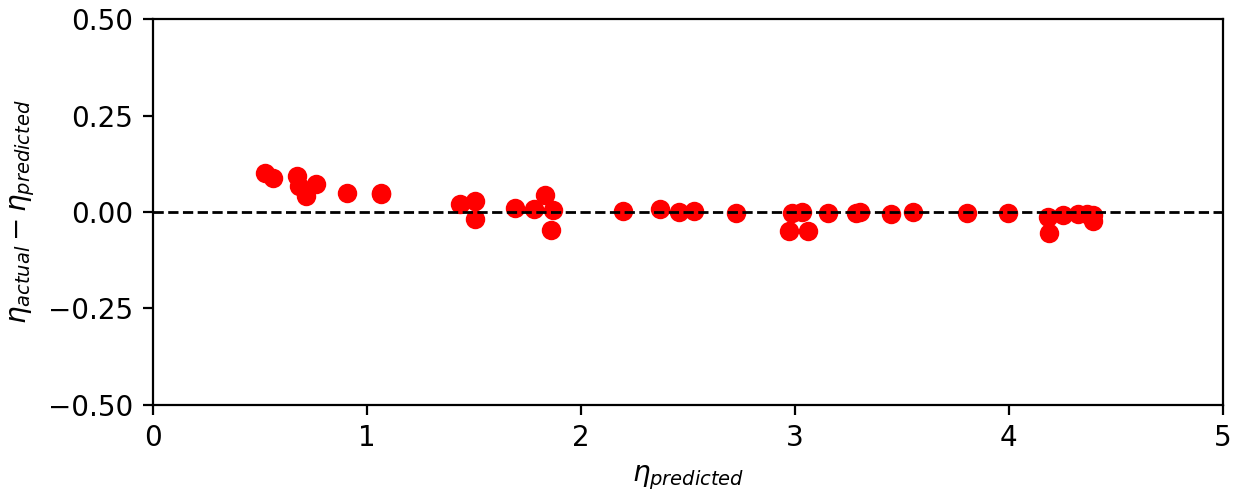

In [27]:
fig,ax = plt.subplots(figsize=(6.2,2.5),constrained_layout=True)
ax.set_xlim(0,N_FID_MAX+1)    
ax.set_ylim(-0.5,0.5)
ax.axhline(0,lw=1.0,linestyle='dashed',c='black')

ax.set_yticks([-0.5,-0.25,0,0.25,0.5])

i=0
for N_SIM in trange(1,N_MONTE):
    ax.scatter(-np.log10(1-predicted[i:i+N_FID_MAX+1]),-np.log10(1-actual[i:i+N_FID_MAX+1])+np.log10(1-predicted[i:i+N_FID_MAX+1]),marker='o',c='red')
    i+=N_FID_MAX+1
    
ax.set_xlabel('$\eta_{predicted}$')
ax.set_ylabel('$\eta_{actual}-\eta_{predicted}$')

std = np.std(-np.log10(1-actual[N_FID_MAX+1:])+np.log10(1-predicted[N_FID_MAX+1:]))
print(std)

In [28]:
fig.savefig("../images/heuristic-accuracy.pdf")